# Bonus1: Parallel Algorithms

### Name: Ayman Elkfrawy


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [84]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [85]:
from sklearn.model_selection import train_test_split

split_random_state = 376

y = y.reshape(len(y), 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.16)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (645, 8)
Shape of x_test: (123, 8)
Shape of y_train: (645, 1)
Shape of y_test: (123, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [86]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.16015059 -0.0308717  -0.06913092  0.01082152  0.1511566   0.05000008
   0.01690519 -0.18163769]]
test std = 
[[0.96263827 1.05218948 1.04996419 0.93040867 1.33588875 1.0865578
  1.14621725 1.01138687]]


## 1.4. Add a dimension of all ones

In [87]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (645, 9)
Shape of x_test: (123, 9)


In [88]:
import math

VERBOSE = False


class Worker:
    def __init__(self, worker_id, x, y):
        self.x = x
        self.y = y
        self.n_samples = x.shape[0]
        self.d_features = x.shape[1]
        self.w = numpy.zeros((self.d_features, 1))
        self.worker_id = worker_id
        self.log('Created')
        self.neighbors = []
        self.grad = 0

    def set_neighbors(self, neighbors):
        self.neighbors = neighbors

    def log(self, message):
        if VERBOSE:
            print(f'Worker ({self.worker_id}): {message}')

    def update_params(self, self_weight=3):
        self.log('Collecting and updating Params')

        neighbors_w = numpy.zeros((self.d_features, 1))
        for neighbor in self.neighbors:
            neighbors_w += neighbor.get_params()

        self.w = (self_weight * self.w + neighbors_w) / (len(self.neighbors) + self_weight)

    def get_params(self):
        return self.w

    def gradient(self, lam):
        self.log('Calculating GD grad')
        yx = numpy.multiply(self.y, self.x)
        yxw = numpy.dot(yx, self.w)
        g_vec = numpy.divide(yx, 1 + numpy.exp(yxw))
        self.grad = -numpy.mean(g_vec, axis=0).reshape(self.d_features, 1) + lam * self.w
        return self.grad

    def objective(self, lam):
        self.log('Calculating GD Objective')
        yx = numpy.multiply(self.y, self.x)
        yxw = numpy.dot(yx, self.w)
        loss = numpy.mean(numpy.log(1 + numpy.exp(-yxw)))
        obj = loss + lam / 2 * numpy.sum(self.w * self.w)
        return obj

    def gd(self, learn_rate, lam):
        self.log('Performing GD')

        self.w -= learn_rate * self.grad

        objval = self.objective(lam)

        return self.w, objval


def create_workers_network(x, y, network):
    n_samples, d_features = x.shape
    m_workers = len(network)
    s = math.floor(n_samples / m_workers)

    workers = []

    for i in range(m_workers):
        indices = list(range(i*s, (i+1) * s))
        worker = Worker('worker'+str(i), x[indices, :], y[indices, :])
        workers.append(worker)

    for i in range(m_workers):
        neighbors = list(map(lambda idx: workers[idx], network[i]))  # map each index in the map to corresponding worker
        workers[i].set_neighbors(neighbors)

    return workers

In [89]:
def run_distributed_optimization(x_train, y_train, self_weight, network_map, lam=1e-6, alpha=1e-1, max_epoch=50):
    if len(network_map) < 1:
        raise Exception('Network must contain at least one worker!')

    workers = create_workers_network(x_train, y_train, network_map)
    m_workers = len(workers)

    objvals = numpy.zeros(max_epoch)
    for epoch in range(max_epoch):
        objval = 0

        for worker in workers:
            worker.gradient(lam)  # Each worker calculate gradient locally
            worker.update_params(self_weight)  # Update parameters from neighbors
            _, obj = worker.gd(learn_rate=alpha, lam=lam)  # Calculate GD with updated parameters
            objval += obj

        objval /= m_workers
        objvals[epoch] = objval
        print('Objective function value = ' + str(objval))

    return workers[0].w, objvals  # Assuming all workers converged

## Network graph
![Distributed Optimization Network](DO_network.png)

In [90]:
#  [0]----[1]-----[3]----[5]
#   |     /       /\      |
#   |   /       /    \    |
#   | /       /        \  |
#  [2]------[4]          [6]
#


In [91]:
network_map = [
    [1, 2],
    [0, 2, 3],
    [0, 1, 4],
    [1, 4, 5, 6],
    [2, 3],
    [3, 6],
    [3, 5]
]


simple_w, do_simple_avg_objvals = run_distributed_optimization(x_train, y_train, network_map=network_map, self_weight=1, lam=1e-6, alpha=1e-1, max_epoch=100)
print('-------------------------')
_, do_weighted_avg_objvals = run_distributed_optimization(x_train, y_train, network_map=network_map, self_weight=5, lam=1e-6, alpha=1e-1, max_epoch=100)

Objective function value = 0.6726036686648535
Objective function value = 0.6545475502975693
Objective function value = 0.6386104777964471
Objective function value = 0.6245512432930378
Objective function value = 0.612127246632146
Objective function value = 0.6011104040887048
Objective function value = 0.5913008275432856
Objective function value = 0.5825285546221474
Objective function value = 0.5746505597776992
Objective function value = 0.567546731021959
Objective function value = 0.5611160528704393
Objective function value = 0.555273315691676
Objective function value = 0.5499463748813359
Objective function value = 0.5450738985600171
Objective function value = 0.540603526046118
Objective function value = 0.5364903639586054
Objective function value = 0.5326957570144517
Objective function value = 0.5291862813245599
Objective function value = 0.5259329176538678
Objective function value = 0.5229103702961161
Objective function value = 0.5200965039488692
Objective function value = 0.517471876

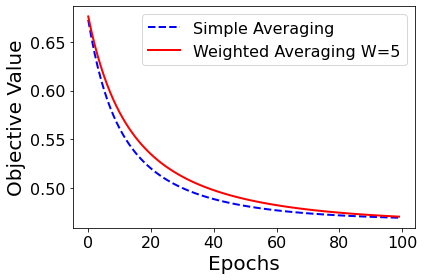

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs = range(len(do_simple_avg_objvals))

line0, = plt.plot(epochs, do_simple_avg_objvals, '--b', linewidth=2)
line1, = plt.plot(epochs, do_weighted_avg_objvals, '-r', linewidth=2)

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1], ['Simple Averaging', 'Weighted Averaging W=5'], fontsize=16)
plt.tight_layout()
plt.show()

In [93]:
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

# evaluate training error using SGD Q=8 params
w = simple_w
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.22170542635658916


In [94]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.22764227642276422
